# Plot prediction derivatives

In [28]:
# sélection du cas test
testcase = 1
version = 2
param_num = 1

In [29]:
assert testcase == 1 and version in [1, 2]
assert param_num <= 4

## Imports + Load

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import seaborn as sns
import dataframe_image as dfi

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.solver_fem_1_1D import FEMSolver
from modules.utils import create_tree
from modules.fenics_expressions_1D import UexExpr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
if version == 1:
    from modules.testcases.d1.test_1.test_1_v1 import Run_laplacian1D,Poisson_1D
elif version == 2:
    from modules.testcases.d1.test_1.test_1_v2 import Run_laplacian1D,Poisson_1D
from modules.problem_1D import TestCase1
problem = TestCase1()

result_dir = "../../results/1D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/plot/"
create_tree(result_dir)

N = 1000

init
Training PINN
init
>> load network /home/flecourtier/Bureau/Article1/code/networks/test_1D/test_fe1_v2.pth
network loaded
Error  tensor([0.0100])


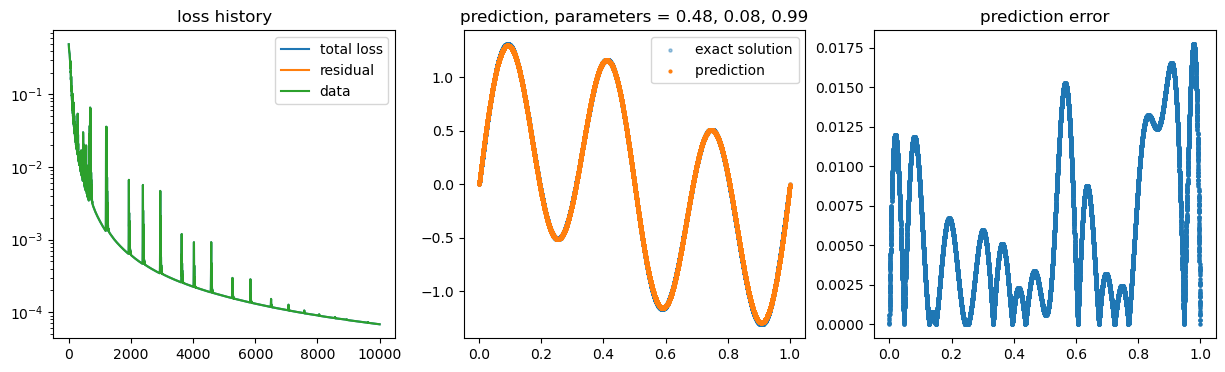

In [33]:
pde = Poisson_1D()
trainer,u_theta = Run_laplacian1D(pde)

In [34]:
test_params = [[0.3, 0.2, 0.1], [0.4, 0.6, 0.3], [0.7, 0.4, 0.6], [0.8, 0.5, 0.8]]
param = test_params[param_num-1]
print(f"param_num = {param_num}, param = {param}")
params = [param]

param_num = 1, param = [0.3, 0.2, 0.1]


In [35]:
XXYY = np.linspace(0, 1, N)
XXYY = XXYY.reshape(-1,1)

X_test = torch.tensor(XXYY,requires_grad=True)
X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

# get parameters
nb_params = len(trainer.pde.parameter_domain)
shape = (XXYY.shape[0],nb_params)
ones = torch.ones(shape)
mu_test = (torch.Tensor(params[0]).to(device) * ones).to(device)

u_ex = pde.reference_solution(X_test, mu_test).cpu().detach().numpy()
du_ex_dx = pde.reference_solution_derivative(X_test, mu_test).cpu().detach().numpy()
d2u_ex_dx2 = pde.reference_solution_second_derivative(X_test, mu_test).cpu().detach().numpy()

pred = u_theta.setup_w_dict(X_test, mu_test)
u_theta.get_first_derivatives(pred, X_test)
u_theta.get_second_derivatives(pred, X_test)
        
u_theta_ = pred["w"][:,0].cpu().detach().numpy()
u_theta_x = pred["w_x"][:,0].cpu().detach().numpy()
u_theta_xx = pred["w_xx"][:,0].cpu().detach().numpy()

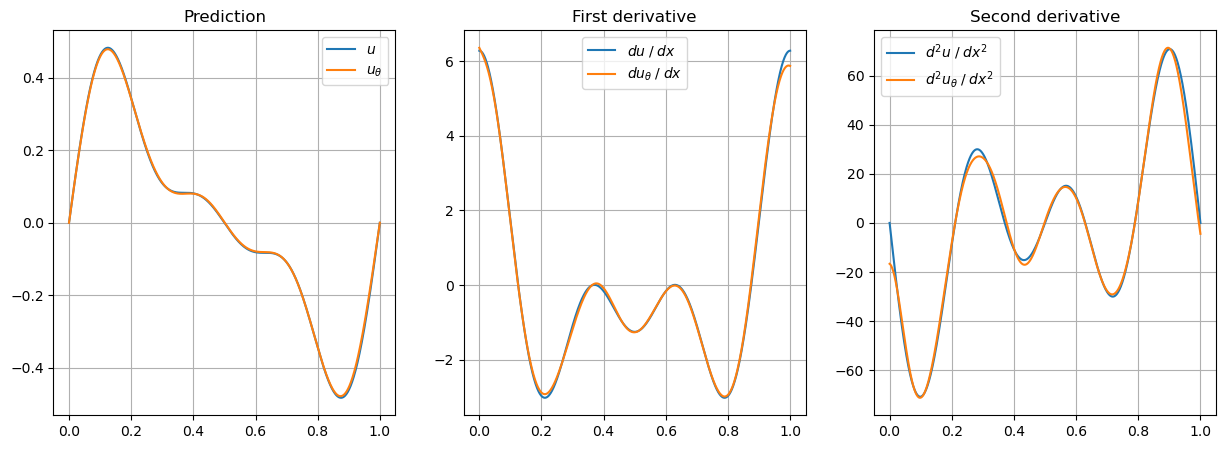

In [36]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

# plot u
axs[0].plot(XXYY, u_ex, label=r"$u$")
axs[0].plot(XXYY, u_theta_, label=r"$u_\theta$")
axs[0].set_title("Prediction")
axs[0].legend()

# plot du/dx
axs[1].plot(XXYY, du_ex_dx, label=r"$du \; / \; dx$")
axs[1].plot(XXYY, u_theta_x, label=r"$du_\theta \; / \; dx$")
axs[1].set_title("First derivative")
axs[1].legend(loc="upper center")

# plot d2u/dx2
axs[2].plot(XXYY, d2u_ex_dx2, label=r"$d^2u \; / \; dx^2$")
axs[2].plot(XXYY, u_theta_xx, label=r"$d^2u_\theta \; / \; dx^2$")
axs[2].set_title("Second derivative")
axs[2].legend()

for ax in axs:
    ax.grid()

plt.savefig(result_dir+"plot_"+str(param_num)+".png",dpi=300)
plt.show()